In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))
#sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().joinpath('Quantum_Annealing_for_Particle_Matching'))))
#sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd())))
#for p in sys.path:
#    print(p)
import os
import time
import h5py
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm
import threading

import dwave
import dwave.system
from src.particle_funcs import distance_matrix as distance_matrix
from src import particle_funcs
from src.particle_funcs import mixing_models
import src.leap_funcs.qubo.q_matrix as q_matrix
from src.leap_funcs import embedding_quality
from src.leap_funcs.qubo import filter_samples
from src._misc import compare_matrices

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


In [2]:
sim_path = pathlib.Path(r'C:\Users\oahre\RWTH\OneDrive - Students RWTH Aachen University\RWTH\Simulation_Sciences\HiWi\Rocky\Rocky_acc\V_Mixer\01_original')
sim_path = sim_path.joinpath(r'01_Particles_3160_CPU_8_GPU_0.rocky.files')
#sim_path = sim_path.joinpath(r'04_Particles_6320_CPU_8_GPU_0.rocky.files')
#sim_path = sim_path.joinpath(r'07_Particles_12641_CPU_8_GPU_0.rocky.files')
#sim_path = sim_path.joinpath(r'10_Particles_17332_CPU_8_GPU_0.rocky.files')
#sim_path = sim_path.joinpath(r'13_Particles_36308_CPU_8_GPU_0.rocky.files')
sim_path = sim_path.joinpath(r'simulation')
sim_path.is_dir()

True

In [3]:
file_list_raw = list(sim_path.iterdir())
print(len(file_list_raw))
file_list = [f for f in file_list_raw if f.suffix=='.rhs']
print(len(file_list))
#file_list

2413
1201


In [4]:
tmp_file_path = file_list[0]
with h5py.File(tmp_file_path, 'r') as f:
    #h5py_funcs.discoveries.discover_hdf5_file_structure(f, print_dataset_values=False)
    num_particles = f['/Particles/'].attrs['n_total_particles'][0]
num_particles

3160

In [5]:
def read_particles_files(files_to_read, start, stop, particles_coords):
    print('    read {} files'.format(stop-start if start > 0 else stop-start+1))
    print('    start: {}'.format(start))
    print('    stop: {}'.format(stop))
    for i,file in tqdm(enumerate(files_to_read[start:stop+1])):
        #print(i+start)
        #print(file)
        with h5py.File(file, 'r') as f:
            if i != 0:
                assert np.all(indices == f['Particles']['particles_index'][:].astype('int32')), "particle indices changed between files"
            indices = f['Particles']['particles_index'][:].astype('int32')
            #print("index : ", indices)
            particles_coords[i+start,indices,0] = f['Particles']['particles_position'].fields(['x'])[:].astype('float64')
            particles_coords[i+start,indices,1] = f['Particles']['particles_position'].fields(['y'])[:].astype('float64')
            particles_coords[i+start,indices,2] = f['Particles']['particles_position'].fields(['z'])[:].astype('float64')
            #print(f['Particles']['particles_position'].fields(['x'])[:])
            #print(f['Particles']['particles_position'].fields(['y'])[:])
            #print(f.attrs['time_value'])
    return

In [6]:
files_to_read = file_list
files_to_read = file_list[:10]
particles_coords = np.zeros((len(files_to_read), num_particles, 3))
print('Files to read: {}'.format(len(files_to_read)))
read_particles_files(files_to_read, 0, len(files_to_read)-1, particles_coords)
#print(particles_coords)

Files to read: 10
    read 10 files
    start: 0
    stop: 9


0it [00:00, ?it/s]

10it [00:00, 197.93it/s]


In [7]:
files_to_read = file_list
#files_to_read = files_to_read[0:-1:50]
particles_coords = np.zeros((len(files_to_read), num_particles, 3))

threads = []
count_threads = 1

a = range(len(files_to_read))
b = np.array_split(a, count_threads)
starts = []
stops = []
for r in b:
    starts.append(r[0])
    stops.append(r[-1])
print(starts)
print(stops)

for i in range(count_threads):
    t = threading.Thread(name=None, target=read_particles_files, args=[files_to_read, starts[i], stops[i], particles_coords])
    threads.append(t)
    t.start()
    time.sleep(0.1)
for t in threads:
    t.join()

#particles_coords
np.amin(particles_coords, axis=(0,1))

[0]
[1200]
    read 1201 files
    start: 0
    stop: 1200


1201it [00:06, 196.14it/s]


array([-0.20082847, -0.20752695, -0.20740447])

In [8]:
colors = np.zeros_like(particles_coords[0,:,0])
colors[np.where(particles_coords[0,:,0]>0)]=1
#colors = np.ones_like(colors)
#colors[0:2] = 0
colors

array([0., 0., 0., ..., 1., 1., 1.])

In [9]:
# average height method

#stride = 50
#avg_heights = np.zeros((len(files_to_read[::stride]), 2))
#for i in range(len(files_to_read[::stride])):
#    avg_heights[i,:] = particle_funcs.mixing_models.average_height(particles_coords[i*stride,:,:],axis=0,species=colors)[:]
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(range(len(files_to_read[::stride])), avg_heights[:,0])
#ax.plot(range(len(files_to_read[::stride])), avg_heights[:,1])

In [10]:
# average neighbours method

#stride = 50
#avg_neighbours = np.zeros((len(files_to_read[::stride]), 2))
#for i in tqdm(range(len(files_to_read[::stride]))):
#    avg_neighbours[i,:] = particle_funcs.mixing_models.nearest_neighbour(particles_coords[i*stride,:,:],species=colors)[:]
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(range(len(files_to_read[::stride])), avg_neighbours[:,0])
#ax.plot(range(len(files_to_read[::stride])), avg_neighbours[:,1])

In [11]:
# laces_index method

#stride = 50
#lacey_index = np.zeros((len(files_to_read[::stride]), 2))
#for i in tqdm(range(len(files_to_read[::stride]))):
#    lacey_index[i,:] = particle_funcs.mixing_models.calc_lacey_index(particles_coords[i*stride,:,:],species=colors, sample_method='random', sample_count=100)
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(range(len(files_to_read[::stride])), lacey_index[:,0])
#ax.plot(range(len(files_to_read[::stride])), lacey_index[:,1])

In [12]:
# mixing_entropy method

#stride = 50
#mixing_entropy = np.zeros((len(files_to_read[::stride]), 1))
#for i in tqdm(range(len(files_to_read[::stride]))):
#    #mixing_entropy[i,:] = particle_funcs.mixing_models.calc_mixing_entropy(particles_coords[i*stride,:,:],species=colors, sample_method='random', sample_count=100)
#    mixing_entropy[i,:] = particle_funcs.mixing_models.calc_mixing_entropy(particles_coords[i*stride,:,:],species=colors, sample_method='equidistant_bounds', bounds={'x':(-0.1,0.1), 'y':(-0.1,0.05), 'z':(-0.07,0.07)}, sample_counts={'x':7, 'y':7, 'z':5})
#fig = plt.figure()
#ax = fig.add_subplot(111)
#ax.plot(range(len(files_to_read[::stride])), mixing_entropy[:,0])
##ax.plot(range(len(files_to_read[::stride])), mixing_entropy[:,1])
#mixing_entropy

In [13]:
# coordination number method

#stride = 50
#coordination_number_index = np.zeros((len(files_to_read[::stride]), 2))
#for i in tqdm(range(len(files_to_read[::stride]))):
#    coordination_number_index[i,:] = particle_funcs.mixing_models.calc_coordination_number_index(particles_coords[i*stride,:,:], species=colors, diameter=0.0)[:]
#fig = plt.figure()
#ax = fig.add_subplot(111)
#for i in range(coordination_number_index.shape[1]):
#    ax.plot(range(len(files_to_read[::stride])), coordination_number_index[:,i])
##ax.plot(range(len(files_to_read[::stride])), coordination_number_index[:,0])
##ax.plot(range(len(files_to_read[::stride])), coordination_number_index[:,1])
#ax.set_ylim(bottom=0)

100%|██████████| 25/25 [00:15<00:00,  1.64it/s]


(0.0, 0.8996530701470078)

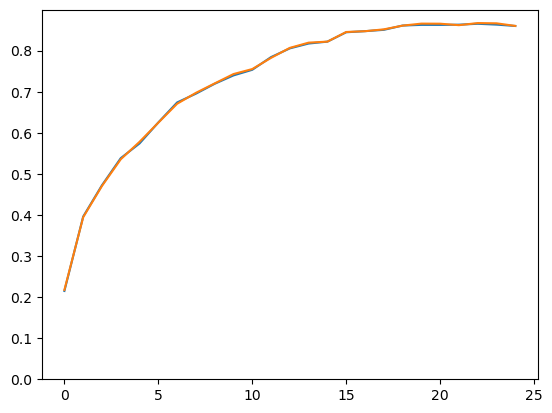

In [14]:
# particle-scale index method

stride = 50
particle_scale_index = np.zeros((len(files_to_read[::stride]), 2))
for i in tqdm(range(len(files_to_read[::stride]))):
    particle_scale_index[i,:] = particle_funcs.mixing_models.calc_particle_scale_index(particles_coords[i*stride,:,:], species=colors, diameter = 0.0, sample_method='random', sample_count=100, kwargs_distance_matrix={}, verbose=0)
#    _tmp = particle_funcs.mixing_models.calc_particle_scale_index(particles_coords[i*stride,:,:], species=colors, diameter = 0.0, sample_method='random', sample_count=100, kwargs_distance_matrix={}, verbose=0)
#for i in range(_tmp.shape[0]):
#    print(_tmp[i])
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(particle_scale_index.shape[1]):
    ax.plot(range(len(files_to_read[::stride])), particle_scale_index[:,i])
#ax.plot(range(len(files_to_read[::stride])), coordination_number_index[:,0])
#ax.plot(range(len(files_to_read[::stride])), coordination_number_index[:,1])
ax.set_ylim(bottom=0)

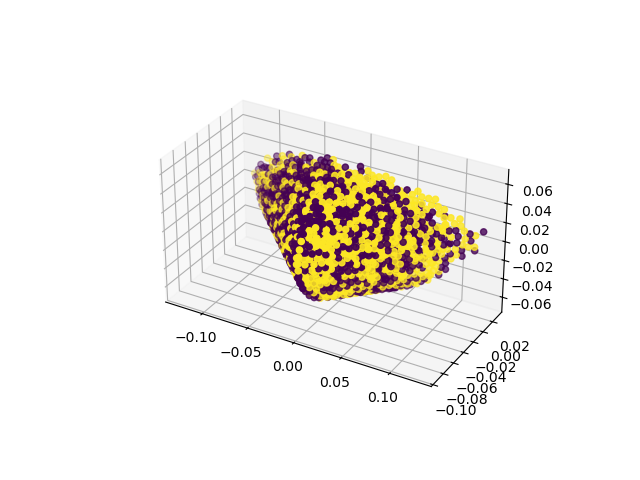

In [14]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(particles_coords[10,:,0], particles_coords[10,:,1], particles_coords[10,:,2])
#colors = np.zeros_like(particles_coords[10,:,0])
#colors[np.where(particles_coords[0,:,0]>0)]=1
step = 1000
ax.scatter(particles_coords[step,:,0], particles_coords[step,:,1], particles_coords[step,:,2], c=colors)
ax.set_aspect('equal')

In [15]:
with h5py.File(file_list[100], 'r') as f:
    print(f.attrs['time_value'])

[5.]


In [16]:
def progress(current_frame: int, total_frames: int):
    print(f'Progress: {current_frame}/{total_frames}', end='\r')

MovieWriter Pillow unavailable; using Pillow instead.


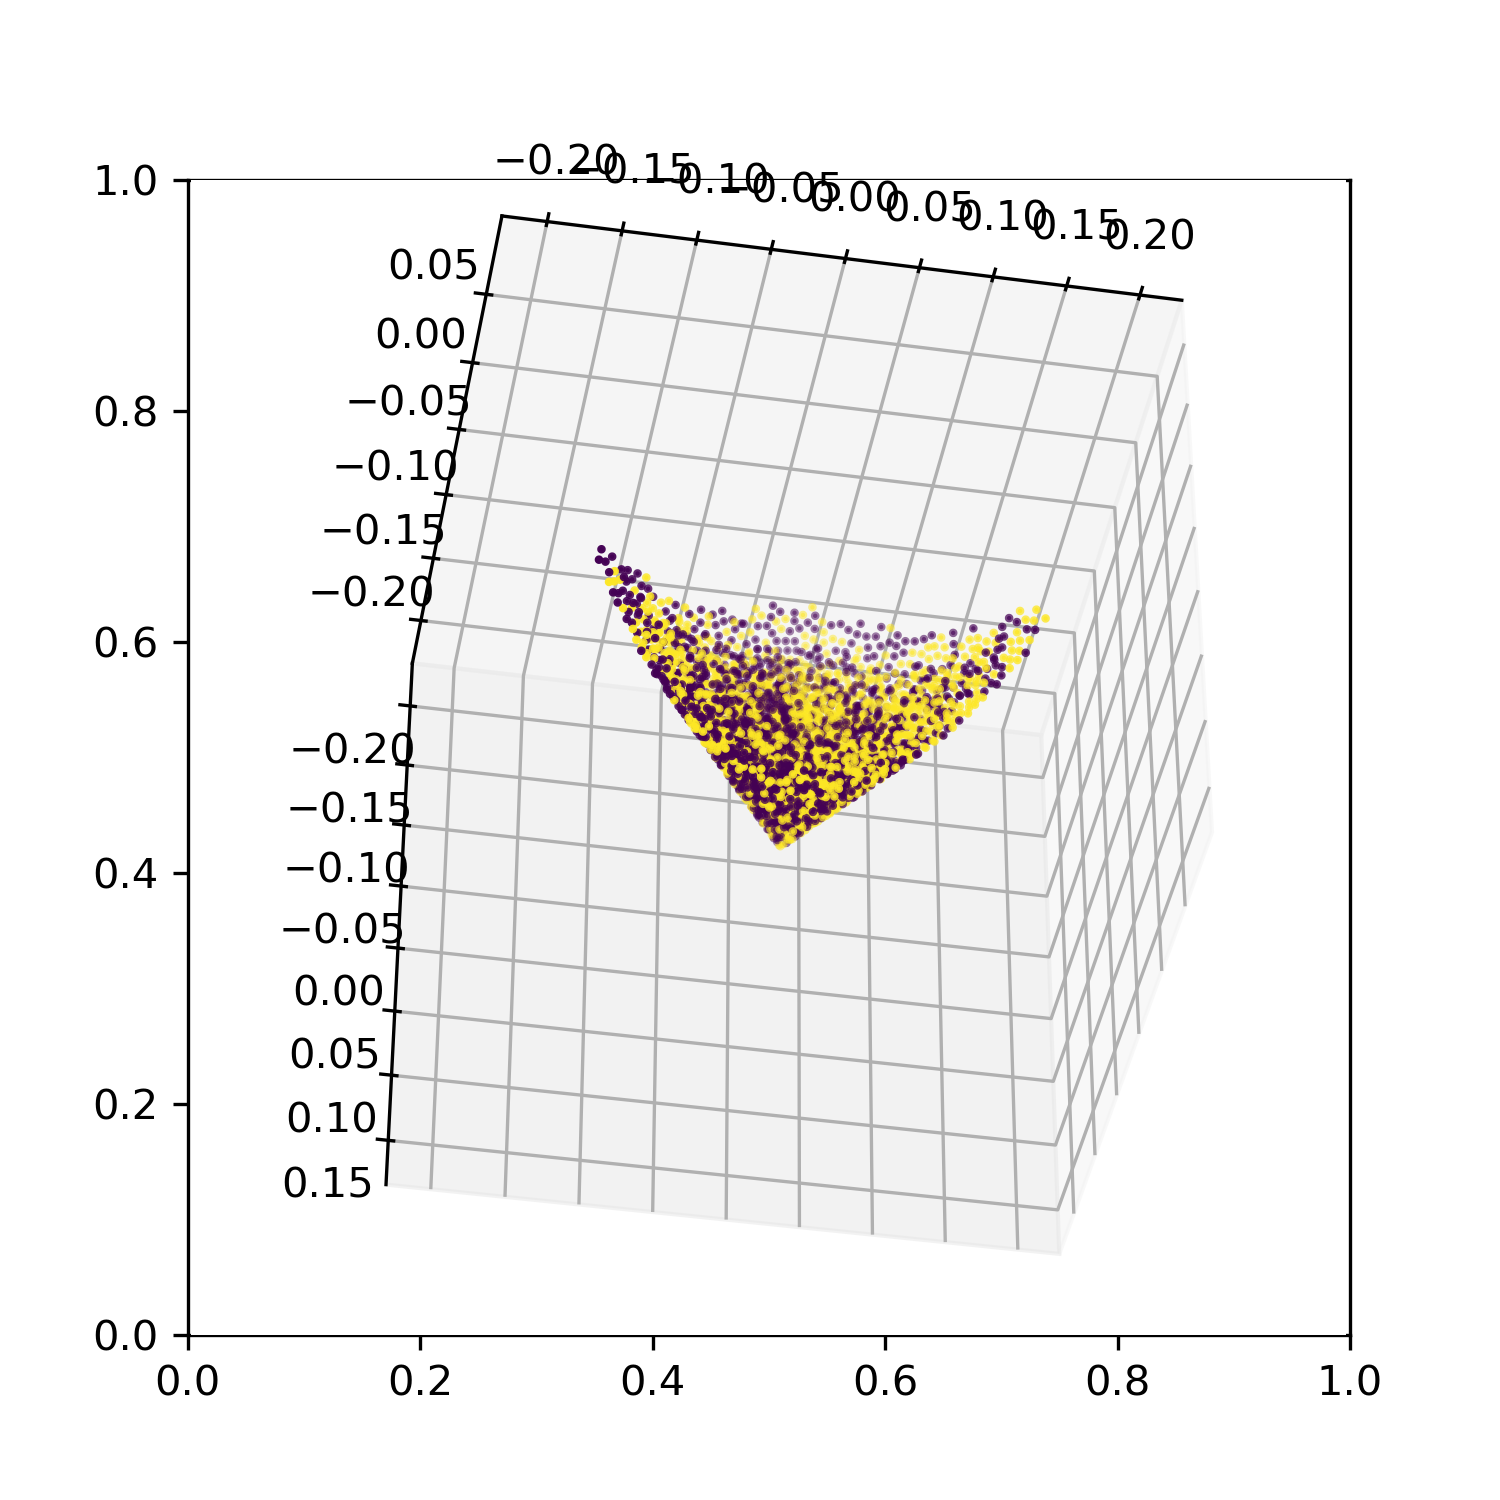

In [17]:
xyz_min = 1.1 * np.amin(particles_coords, axis=(0,1))
xyz_max = 1.1 * np.amax(particles_coords, axis=(0,1))
colours = 1.1 * np.zeros_like(particles_coords[10,:,0])
colours[np.where(particles_coords[0,:,0]>0)]=1
dpi = 300

fig, ax = plt.subplots(figsize=(5,5), dpi=dpi)
ax = fig.add_subplot(projection='3d')

ax.set_aspect('equal')
ax.set_xlim(xyz_min[0], xyz_max[0])
ax.set_ylim(xyz_min[1], xyz_max[1])
ax.set_zlim(xyz_min[2], xyz_max[2])
ax.azim = -80
ax.elev = 140
ax.roll = 0
scat = ax.scatter(particles_coords[0,:,0], particles_coords[0,:,1], particles_coords[0,:,2], c=colours, s=1.1)

def animate(i):
    scat._offsets3d = (particles_coords[0+i,:,0], particles_coords[0+i,:,1], particles_coords[0+i,:,2])
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True, frames=len(files_to_read) - 1, interval=50)

ani.save('V_Mixer_{}.gif'.format(num_particles), writer='Pillow', fps=20, progress_callback=progress, dpi=dpi)